# Compute metrics across peak subsets

In [1]:
import sys
# append paths pointing to Data directory on your machine
sys.path.append('/home/katie/bp_repo/multitask_profile_model_SPI_GATA')

import pickle
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py

import profile_models
import profile_performance
from profile_performance import load_metrics, compute_performance_metrics, log_performance_metrics
from all_functions import save_preds_by_subset

sys.path.append('/home/katie/bp_repo/reports/')
from util import import_profiles

In [3]:
# set variables
subsets_path_root = '/home/katie/bp_repo/reports/katie_notebooks/round2_tasks_mar2022/TASK_1/'
model_path_root = '/home/katie/bp_repo/pipeline_outputs/'
save_path_root = '/home/katie/bp_repo/reports/katie_notebooks/summer2022_analysis/preds_by_subset/'

model_paths = list(model_path_root + stem + '/model.state_dict' for stem in ['ctcf_chipseq_jul6',
                                                         'ctcf_cutnrun_jul6', 'fosl2_chipseq_jul6', 'fosl2_cutnrun_jul6'])
models = list(profile_models.ModelLoader(model_path, controls='chipseq' in model_path, num_tasks=1).load_model() for \
             model_path in model_paths)

tfs = ['CTCF'] * 2 + ['FOSL2'] * 2
assays = ['chip-seq', 'cutnrun'] * 2
controls = list(assay == 'chip-seq' for assay in assays)
save_paths = list(save_path_root + tfs[i] + '/' + assays[i] + '_model/' for i in range(len(tfs)))
peak_subsets = ['unique', 'shared']


path_ids = ['CTCF chip-seq model', 'CTCF cutnrun model', 'FOSL2 chip-seq model', 'FOSL2 cutnrun model']

keys = ['shared_chip_loader',
 'shared_cut_loader',
 'unique_chip_loader',
 'unique_cut_loader']

data_ids = ['true_counts', 'log_pred_counts', 'true_profs', 'log_pred_profs']
plt.rcParams['figure.dpi'] = 100

## Save preds by subset

In [3]:
# save preds by subset
for i in range(len(tfs)):
    model, tf, assay, control, save_path = models[i], tfs[i], assays[i], controls[i], save_paths[i]
    for peak_subset in peak_subsets:
        save_preds_by_subset(model, tf, assay, control, save_path, peak_subset, chrom_subset='test')

This is NOT the assay: cutnrun
Tasks path: /home/katie/bp_repo/research/data/chip-seq/
TSV path: CTCF_chip_unique_no_cut
CTCF
/home/katie/bp_repo/reports/katie_notebooks/round2_tasks_mar2022/TASK_1/CTCF_chip_unique_no_cut
(4980, 14)
Index(['chrom', 'peak_start', 'peak_end', 'name', 'score', 'strand', 'signal',
       'pval', 'qval', 'summit_offset', 'i0', 'start', 'end', 'task'],
      dtype='object')


  0%|          | 0/4 [00:00<?, ?it/s]

Saving result to HDF5...
Tasks path: /home/katie/bp_repo/research/data/chip-seq/
TSV path: CTCF_cut_unique_no_chip
CTCF
/home/katie/bp_repo/reports/katie_notebooks/round2_tasks_mar2022/TASK_1/CTCF_cut_unique_no_chip
(24246, 23)
Index(['chrom', 'peak_start', 'peak_end', 'name', 'score', 'strand', 'signal',
       'pval', 'qval', 'summit_offset', 'i0', 'i1', 'i2', 'i3', 'i4', 'i5',
       'i6', 'i7', 'i8', 'i9', 'start', 'end', 'task'],
      dtype='object')


  0%|          | 0/17 [00:00<?, ?it/s]

Saving result to HDF5...
This is NOT the assay: cutnrun
Tasks path: /home/katie/bp_repo/research/data/chip-seq/
TSV path: CTCF_chip_unique_shared_cut
CTCF
/home/katie/bp_repo/reports/katie_notebooks/round2_tasks_mar2022/TASK_1/CTCF_chip_unique_shared_cut
(30821, 14)
Index(['chrom', 'peak_start', 'peak_end', 'name', 'score', 'strand', 'signal',
       'pval', 'qval', 'summit_offset', 'i0', 'start', 'end', 'task'],
      dtype='object')


  0%|          | 0/23 [00:00<?, ?it/s]

Saving result to HDF5...
Tasks path: /home/katie/bp_repo/research/data/chip-seq/
TSV path: CTCF_cut_unique_shared_chip
CTCF
/home/katie/bp_repo/reports/katie_notebooks/round2_tasks_mar2022/TASK_1/CTCF_cut_unique_shared_chip
(29979, 23)
Index(['chrom', 'peak_start', 'peak_end', 'name', 'score', 'strand', 'signal',
       'pval', 'qval', 'summit_offset', 'i0', 'i1', 'i2', 'i3', 'i4', 'i5',
       'i6', 'i7', 'i8', 'i9', 'start', 'end', 'task'],
      dtype='object')


  0%|          | 0/22 [00:00<?, ?it/s]

Saving result to HDF5...
This is NOT the assay: chip-seq
Tasks path: /home/katie/bp_repo/research/data/cutnrun/
TSV path: CTCF_cut_unique_no_chip
CTCF
/home/katie/bp_repo/reports/katie_notebooks/round2_tasks_mar2022/TASK_1/CTCF_cut_unique_no_chip
(24246, 23)
Index(['chrom', 'peak_start', 'peak_end', 'name', 'score', 'strand', 'signal',
       'pval', 'qval', 'summit_offset', 'i0', 'i1', 'i2', 'i3', 'i4', 'i5',
       'i6', 'i7', 'i8', 'i9', 'start', 'end', 'task'],
      dtype='object')


  0%|          | 0/17 [00:00<?, ?it/s]

Saving result to HDF5...
Tasks path: /home/katie/bp_repo/research/data/cutnrun/
TSV path: CTCF_chip_unique_no_cut
CTCF
/home/katie/bp_repo/reports/katie_notebooks/round2_tasks_mar2022/TASK_1/CTCF_chip_unique_no_cut
(4980, 14)
Index(['chrom', 'peak_start', 'peak_end', 'name', 'score', 'strand', 'signal',
       'pval', 'qval', 'summit_offset', 'i0', 'start', 'end', 'task'],
      dtype='object')


  0%|          | 0/4 [00:00<?, ?it/s]

Saving result to HDF5...
This is NOT the assay: chip-seq
Tasks path: /home/katie/bp_repo/research/data/cutnrun/
TSV path: CTCF_cut_unique_shared_chip
CTCF
/home/katie/bp_repo/reports/katie_notebooks/round2_tasks_mar2022/TASK_1/CTCF_cut_unique_shared_chip
(29979, 23)
Index(['chrom', 'peak_start', 'peak_end', 'name', 'score', 'strand', 'signal',
       'pval', 'qval', 'summit_offset', 'i0', 'i1', 'i2', 'i3', 'i4', 'i5',
       'i6', 'i7', 'i8', 'i9', 'start', 'end', 'task'],
      dtype='object')


  0%|          | 0/22 [00:00<?, ?it/s]

Saving result to HDF5...
Tasks path: /home/katie/bp_repo/research/data/cutnrun/
TSV path: CTCF_chip_unique_shared_cut
CTCF
/home/katie/bp_repo/reports/katie_notebooks/round2_tasks_mar2022/TASK_1/CTCF_chip_unique_shared_cut
(30821, 14)
Index(['chrom', 'peak_start', 'peak_end', 'name', 'score', 'strand', 'signal',
       'pval', 'qval', 'summit_offset', 'i0', 'start', 'end', 'task'],
      dtype='object')


  0%|          | 0/23 [00:00<?, ?it/s]

Saving result to HDF5...
This is NOT the assay: cutnrun
Tasks path: /home/katie/bp_repo/research/data/chip-seq/
TSV path: FOSL2_chip_unique_no_cut
FOSL2
/home/katie/bp_repo/reports/katie_notebooks/round2_tasks_mar2022/TASK_1/FOSL2_chip_unique_no_cut
(6960, 14)
Index(['chrom', 'peak_start', 'peak_end', 'name', 'score', 'strand', 'signal',
       'pval', 'qval', 'summit_offset', 'i0', 'start', 'end', 'task'],
      dtype='object')


  0%|          | 0/5 [00:00<?, ?it/s]

Saving result to HDF5...
Tasks path: /home/katie/bp_repo/research/data/chip-seq/
TSV path: FOSL2_cut_unique_no_chip
FOSL2
/home/katie/bp_repo/reports/katie_notebooks/round2_tasks_mar2022/TASK_1/FOSL2_cut_unique_no_chip
(20169, 23)
Index(['chrom', 'peak_start', 'peak_end', 'name', 'score', 'strand', 'signal',
       'pval', 'qval', 'summit_offset', 'i0', 'i1', 'i2', 'i3', 'i4', 'i5',
       'i6', 'i7', 'i8', 'i9', 'start', 'end', 'task'],
      dtype='object')


  0%|          | 0/14 [00:00<?, ?it/s]

Saving result to HDF5...
This is NOT the assay: cutnrun
Tasks path: /home/katie/bp_repo/research/data/chip-seq/
TSV path: FOSL2_chip_unique_shared_cut
FOSL2
/home/katie/bp_repo/reports/katie_notebooks/round2_tasks_mar2022/TASK_1/FOSL2_chip_unique_shared_cut
(26508, 14)
Index(['chrom', 'peak_start', 'peak_end', 'name', 'score', 'strand', 'signal',
       'pval', 'qval', 'summit_offset', 'i0', 'start', 'end', 'task'],
      dtype='object')


  0%|          | 0/20 [00:00<?, ?it/s]

Saving result to HDF5...
Tasks path: /home/katie/bp_repo/research/data/chip-seq/
TSV path: FOSL2_cut_unique_shared_chip
FOSL2
/home/katie/bp_repo/reports/katie_notebooks/round2_tasks_mar2022/TASK_1/FOSL2_cut_unique_shared_chip
(25420, 23)
Index(['chrom', 'peak_start', 'peak_end', 'name', 'score', 'strand', 'signal',
       'pval', 'qval', 'summit_offset', 'i0', 'i1', 'i2', 'i3', 'i4', 'i5',
       'i6', 'i7', 'i8', 'i9', 'start', 'end', 'task'],
      dtype='object')


  0%|          | 0/19 [00:00<?, ?it/s]

Saving result to HDF5...
This is NOT the assay: chip-seq
Tasks path: /home/katie/bp_repo/research/data/cutnrun/
TSV path: FOSL2_cut_unique_no_chip
FOSL2
/home/katie/bp_repo/reports/katie_notebooks/round2_tasks_mar2022/TASK_1/FOSL2_cut_unique_no_chip
(20169, 23)
Index(['chrom', 'peak_start', 'peak_end', 'name', 'score', 'strand', 'signal',
       'pval', 'qval', 'summit_offset', 'i0', 'i1', 'i2', 'i3', 'i4', 'i5',
       'i6', 'i7', 'i8', 'i9', 'start', 'end', 'task'],
      dtype='object')


  0%|          | 0/14 [00:00<?, ?it/s]

Saving result to HDF5...
Tasks path: /home/katie/bp_repo/research/data/cutnrun/
TSV path: FOSL2_chip_unique_no_cut
FOSL2
/home/katie/bp_repo/reports/katie_notebooks/round2_tasks_mar2022/TASK_1/FOSL2_chip_unique_no_cut
(6960, 14)
Index(['chrom', 'peak_start', 'peak_end', 'name', 'score', 'strand', 'signal',
       'pval', 'qval', 'summit_offset', 'i0', 'start', 'end', 'task'],
      dtype='object')


  0%|          | 0/5 [00:00<?, ?it/s]

Saving result to HDF5...
This is NOT the assay: chip-seq
Tasks path: /home/katie/bp_repo/research/data/cutnrun/
TSV path: FOSL2_cut_unique_shared_chip
FOSL2
/home/katie/bp_repo/reports/katie_notebooks/round2_tasks_mar2022/TASK_1/FOSL2_cut_unique_shared_chip
(25420, 23)
Index(['chrom', 'peak_start', 'peak_end', 'name', 'score', 'strand', 'signal',
       'pval', 'qval', 'summit_offset', 'i0', 'i1', 'i2', 'i3', 'i4', 'i5',
       'i6', 'i7', 'i8', 'i9', 'start', 'end', 'task'],
      dtype='object')


  0%|          | 0/19 [00:00<?, ?it/s]

Saving result to HDF5...
Tasks path: /home/katie/bp_repo/research/data/cutnrun/
TSV path: FOSL2_chip_unique_shared_cut
FOSL2
/home/katie/bp_repo/reports/katie_notebooks/round2_tasks_mar2022/TASK_1/FOSL2_chip_unique_shared_cut
(26508, 14)
Index(['chrom', 'peak_start', 'peak_end', 'name', 'score', 'strand', 'signal',
       'pval', 'qval', 'summit_offset', 'i0', 'start', 'end', 'task'],
      dtype='object')


  0%|          | 0/20 [00:00<?, ?it/s]

Saving result to HDF5...


## Load in all test set predictions

In [3]:
# load in all test set predictions
all_preds_dict = {}

for i in range(len(save_paths)):
    path = save_paths[i]
    path_id = path_ids[i]
    preds_dict = {}
    
    # the surprisingly quick (few secs) actual preds loading
    for key in keys:
        file = h5py.File(f'{path}{key}.preds', 'r')
        coords = import_profiles(f'{path}{key}.preds')[2]
        preds_dict[key] = {'true_counts': file['predictions']['true_counts'], 
                           'log_pred_counts': file['predictions']['log_pred_counts'], 
                           'true_profs': file['predictions']['true_profs'],
                           'log_pred_profs': file['predictions']['log_pred_profs'], 
                           'coords': coords}
        
        # we need to subset to chr1, the test set
            # 1. take the coords, make into a DataFrame, subset to chr1, and get the indexes of the test coords
            # 2. use these indexes to subset pred_counts into the test profs
        df = pd.DataFrame(preds_dict[key]['coords']).reset_index()
        preds_dict[key]['coords_test'] = df[df.iloc[:,1] == 'chr1']
        preds_dict[key]['indexes_test'] = list(preds_dict[key]['coords_test']['index'])
        
        for data_id in data_ids:  # update all of the data to ONLY include test data
            preds_dict[key][data_id] = preds_dict[key][data_id][preds_dict[key]['indexes_test']]
    
    all_preds_dict[path_id] = preds_dict

Importing predictions:   0%|          | 0/6 [00:00<?, ?it/s]

Importing predictions:   0%|          | 0/6 [00:00<?, ?it/s]

Importing predictions:   0%|          | 0/1 [00:00<?, ?it/s]

Importing predictions:   0%|          | 0/5 [00:00<?, ?it/s]

Importing predictions:   0%|          | 0/6 [00:00<?, ?it/s]

Importing predictions:   0%|          | 0/6 [00:00<?, ?it/s]

Importing predictions:   0%|          | 0/1 [00:00<?, ?it/s]

Importing predictions:   0%|          | 0/5 [00:00<?, ?it/s]

Importing predictions:   0%|          | 0/5 [00:00<?, ?it/s]

Importing predictions:   0%|          | 0/5 [00:00<?, ?it/s]

Importing predictions:   0%|          | 0/2 [00:00<?, ?it/s]

Importing predictions:   0%|          | 0/4 [00:00<?, ?it/s]

Importing predictions:   0%|          | 0/5 [00:00<?, ?it/s]

Importing predictions:   0%|          | 0/5 [00:00<?, ?it/s]

Importing predictions:   0%|          | 0/2 [00:00<?, ?it/s]

Importing predictions:   0%|          | 0/4 [00:00<?, ?it/s]

## Save metrics (pickling)

In [7]:
# save metrics
# only need to run once
for i in range(len(path_ids)):
    path_id = path_ids[i]
    save_path = save_paths[i]
    for key in keys:
        preds_dict = all_preds_dict[path_id][key]
        true_profs, log_pred_profs, true_counts, log_pred_counts = \
        preds_dict['true_profs'], preds_dict['log_pred_profs'], preds_dict['true_counts'], preds_dict['log_pred_counts']
        metrics = profile_performance.compute_performance_metrics(
                true_profs, log_pred_profs, true_counts, log_pred_counts,
                prof_smooth_kernel_sigma=7, prof_smooth_kernel_width=81, print_updates=False
            )

        pickle.dump(profile_performance.log_performance_metrics(metrics), open(save_path + key + '_metrics.pkl', 'wb'))

	Test profile NLL: 213.997897
	Test profile cross entropy: 5.799258
	Test profile JSD: 0.125262
	Test profile Pearson: 0.790660
	Test profile Spearman: 0.593470
	Test profile MSE: 0.000002
	Test count Pearson: 0.233888
	Test count Spearman: 0.242361
	Test count MSE: 0.973231


/home/katie/bp_repo/multitask_profile_model_SPI_GATA/profile_performance.py:43: RuntimeWarning: invalid value encountered in true_divide
  cross_ent = (-log_prob_pows_sum) / trials


	Test profile NLL: 213.548737
	Test profile cross entropy: 5.795738
	Test profile JSD: 0.125937
	Test profile Pearson: 0.788692
	Test profile Spearman: 0.592907
	Test profile MSE: 0.000002
	Test count Pearson: 0.246767
	Test count Spearman: 0.259126
	Test count MSE: 0.990603
	Test profile NLL: 118.424368
	Test profile cross entropy: 6.022300
	Test profile JSD: 0.217622
	Test profile Pearson: 0.637231
	Test profile Spearman: 0.501469
	Test profile MSE: 0.000004
	Test count Pearson: 0.194651
	Test count Spearman: 0.165882
	Test count MSE: 0.277827
	Test profile NLL: 67.967874
	Test profile cross entropy: 6.799979
	Test profile JSD: 0.397298
	Test profile Pearson: 0.161837
	Test profile Spearman: 0.193510
	Test profile MSE: 0.000009
	Test count Pearson: 0.175710
	Test count Spearman: 0.195075
	Test count MSE: 1.369871
	Test profile NLL: 221.008060
	Test profile cross entropy: 4.826022
	Test profile JSD: 0.332676
	Test profile Pearson: 0.322312
	Test profile Spearman: 0.341610
	Test profil

## Load metrics into pretty dataframe :]

In [4]:
pickles = []
ids = []
for i in range(len(path_ids)):
    path_id = path_ids[i]
    save_path = save_paths[i]
    for key in keys:
        pickles.append(save_path + key + '_metrics.pkl')
        ids.append(path_id + ' on ' + ' '.join(key.split('_')[:-1]) + ' peaks')

In [9]:
# OLD, WITHOUT MULTI-INDEXING
metrics = load_metrics(pickles, ids, multiindexing=False)

metrics = metrics.append(load_metrics(['/home/katie/bp_repo/pipeline_outputs/ctcf_chipseq_jul6/metrics.pkl',
              '/home/katie/bp_repo/pipeline_outputs/ctcf_cutnrun_jul6/metrics.pkl',
              '/home/katie/bp_repo/pipeline_outputs/fosl2_chipseq_jul6/metrics.pkl',
              '/home/katie/bp_repo/pipeline_outputs/fosl2_cutnrun_jul6/metrics.pkl'],
             ['CTCF chip-seq model on all test peaks', 'CTCF cutnrun model on all test peaks', 
              'FOSL2 chip-seq model on all test peaks', 'FOSL2 cutnrun model on all test peaks'], multiindexing=False))

In [5]:
metrics = load_metrics(pickles, [path_ids, list(' '.join(key.split('_')) for key in keys)], multiindexing=True)
metrics = pd.concat([metrics, load_metrics(['/home/katie/bp_repo/pipeline_outputs/ctcf_chipseq_jul6/metrics.pkl',
              '/home/katie/bp_repo/pipeline_outputs/ctcf_cutnrun_jul6/metrics.pkl',
              '/home/katie/bp_repo/pipeline_outputs/fosl2_chipseq_jul6/metrics.pkl',
              '/home/katie/bp_repo/pipeline_outputs/fosl2_cutnrun_jul6/metrics.pkl'],
             [path_ids, ['all test peaks']], multiindexing=True)]).sort_index()
metrics = metrics.astype(float).round(2)

CTCF/chip-seq_model/shared_chip_loader_metrics.pkl
('CTCF chip-seq model', 'shared chip loader')


/CTCF/chip-seq_model/shared_cut_loader_metrics.pkl
('CTCF chip-seq model', 'shared cut loader')


CTCF/chip-seq_model/unique_chip_loader_metrics.pkl
('CTCF chip-seq model', 'unique chip loader')


/CTCF/chip-seq_model/unique_cut_loader_metrics.pkl
('CTCF chip-seq model', 'unique cut loader')


/CTCF/cutnrun_model/shared_chip_loader_metrics.pkl
('CTCF cutnrun model', 'shared chip loader')


t/CTCF/cutnrun_model/shared_cut_loader_metrics.pkl
('CTCF cutnrun model', 'shared cut loader')


/CTCF/cutnrun_model/unique_chip_loader_metrics.pkl
('CTCF cutnrun model', 'unique chip loader')


t/CTCF/cutnrun_model/unique_cut_loader_metrics.pkl
('CTCF cutnrun model', 'unique cut loader')


OSL2/chip-seq_model/shared_chip_loader_metrics.pkl
('FOSL2 chip-seq model', 'shared chip loader')


FOSL2/chip-seq_model/shared_cut_loader_metrics.pkl
('FOSL2 chip-seq model', 'shared cut loader')


OSL2/chip-seq_mod

In [8]:
metrics.loc['FOSL2 chip-seq model':'FOSL2 cutnrun model',['Test profile JSD', 'Test count Pearson', 'Test count Spearman']]

Test profile JSD  Test count Pearson  \
FOSL2 chip-seq model all test peaks                  0.12                0.60   
                     shared chip loader              0.11                0.10   
                     shared cut loader               0.11                0.11   
                     unique chip loader              0.16                0.01   
                     unique cut loader               0.23                0.24   
FOSL2 cutnrun model  all test peaks                  0.42                0.15   
                     shared chip loader              0.39                0.08   
                     shared cut loader               0.38                0.09   
                     unique chip loader              0.50               -0.01   
                     unique cut loader               0.47                0.21   

                                         Test count Spearman  
FOSL2 chip-seq model all test peaks                     0.59  
                     shared chip loader                 0.07  
                     shared cut loader                  0.07  
                     unique chip loader                 0.00  
                     unique cut loader                  0.26  
FOSL2 cutnrun model  all test peaks                     0.14  
                     shared chip loader                 0.07  
                     shared cut loader                  0.08  
                     unique chip loader                -0.02  
                     unique cut loader                  0.21

In [70]:
def plot_metrics(tf, metric):
    subsets = ['shared chip loader', 'shared cut loader', 'unique chip loader', 'unique cut loader']
    
    labels = ['Shared ChIP-seq', 'Shared CUT&RUN', 'Unique ChIP-seq', 'Unique CUT&RUN']
    
    chip_rects_values = list(metrics.loc[(f'{tf} chip-seq model', subset), metric] for subset in subsets)
    cut_rects_values = list(metrics.loc[(f'{tf} cutnrun model', subset), metric] for subset in subsets)
    
    width = 0.4       # the width of the bars: can also be len(x) sequence
    ind = np.arange(len(labels))

    fig, ax = plt.subplots()

    # ChIP-seq model
    chip_rects = ax.bar(ind - width/2, chip_rects_values, width, label='ChIP-seq model')

    # CUT&RUN model
    cut_rects = ax.bar(ind + width/2, cut_rects_values, width, label='CUT&RUN model')

    ax.set_xticks(ind, labels, rotation=30)
    ax.set_xlabel('Peak subset')
    ax.set_ylabel(metric)
    ax.set_title(f'{tf} model performance on peak subsets')
    ax.legend()

    ax.bar_label(chip_rects, padding=1, fontsize=8)
    ax.bar_label(cut_rects, padding=1, fontsize=8)

    plt.show()

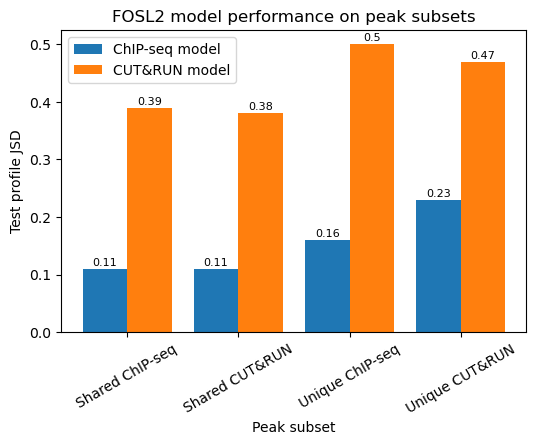

In [73]:
plot_metrics('FOSL2', 'Test profile JSD')

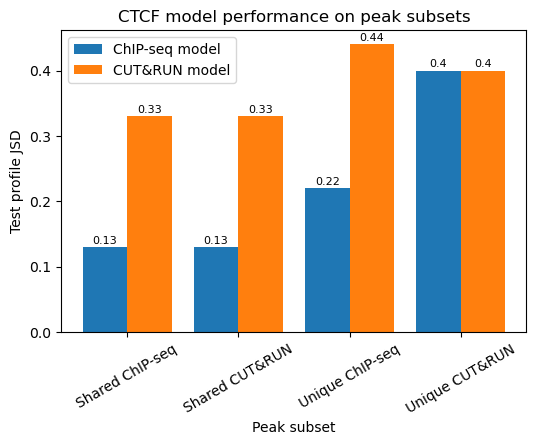

In [74]:
plot_metrics('CTCF', 'Test profile JSD')